# Fundamentals of Supervised Learning

This notebook was written with the desire to soldify machine learning knowledge from
* **CS170** --> Introduction to Machine Learning & Data Mining by Christian Shelton
* **DeepLearning.ai & Stanford ONLINE** --> Machine Learning Specialization by Andrew Ng

In [549]:
# all modules used in this notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

# personal color pallete
c_ = {
    'red': '#ff6188',
    'orange': '#fc9867',
    'yellow': '#ffd866',
    'green': '#a8dd76',
    'blue': '#78dce8',
    'purple': '#ac9df2',
    'grey': '#2c2a2e',
    'white': '#fcfcfa',
    'black': '#211f22' 
}

# global params
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.facecolor'] = c_['black']
plt.rcParams['axes.facecolor'] = c_['black']
plt.rcParams['text.color'] = c_['white']
plt.rcParams['axes.labelcolor'] = c_['white']
plt.rcParams['xtick.color'] = c_['white']
plt.rcParams['ytick.color'] = c_['white']

## Data Generation

This synthetic data represents the performance of **100 students** in a morning university course on machine learning. At the end of a lecture, students were given a pop quiz to assess their understanding of the material. An AI-powered camera estimated the amount of time (in minutes) each student remained focused during the lecture, recorded as the **focus time** (x-axis). The final **quiz scores** were also recorded (y-axis).

The relationship between focus time and quiz scores is modeled using the function:

$$y = (0.08*x - 3)^3 + 20$$

where:
- $y$: Quiz score (percentage)
- $x$: Focus time (minutes)

The following visualizes this relationship using synthetic data generated for 100 students.

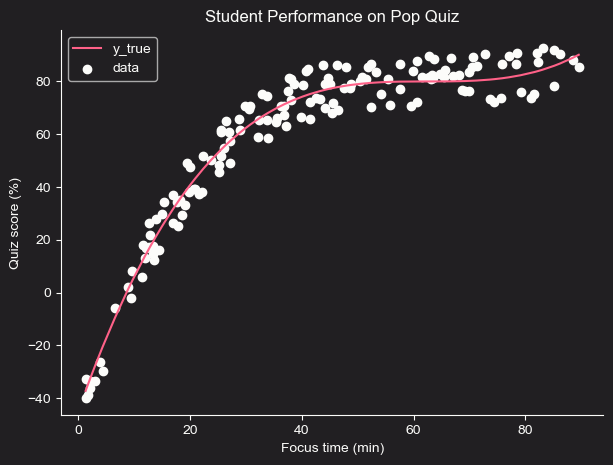

In [550]:
SEED = 819
ERROR = 10

np.random.seed(SEED)
# sample data
n_students = 150
x = np.sort(np.random.uniform(low=1, high=90, size=n_students))
noise = np.random.uniform(low=-ERROR, high=ERROR, size=n_students)

# target function
y_true = (0.08*x - 5)**3 + 80
y = y_true + noise

# graph
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x, y_true, c=c_['red'], label='y_true')
ax.scatter(x, y, c=c_['white'], label='data')
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(c_['white'])
ax.set_title('Student Performance on Pop Quiz')
ax.set_xlabel('Focus time (min)')
ax.set_ylabel('Quiz score (%)')
ax.legend(loc='upper left');

### Supervised Learning

In **supervised learning**, a model is trained (or fitted) to predict the correct output using **labeled data** (input–output pairs). The learning process involves feeding this labeled data into the model so it can learn the relationship between inputs (features) and outputs (targets).

- The choice of model depends on:
  - The type of features data (input variable)
  - The type of target data (output variable)
  - The relationships between features and output
- Supervised learning models are grouped into two main categories:
  - **Regression** → predicts **continuous outcomes** (e.g., price, temperature)
  - **Classification** → predicts **discrete outcomes** (e.g., spam vs. not spam, disease vs. no disease)

Let’s start by exploring the first type: **Regression**.


## Linear Regression for Multiple Features

The hypothesis function is:
$$f(\vec{x}) = w_1x_1 + w_2x_2 + ... + w_nx_n + b$$
$$f(\vec{x}) = \vec{w}^T\vec{x} + b$$

where in each example $\vec{x}$ (e.g., a student):
* $x$: value of each feature
* $w$: weight value for each feature *(controls the importance or influence of each feature on predicted output)*
* $b$: bias unit *(enables the model can fit data not necessarily passing through the origin)*

To simplify code implementation of linear regression, $w_0 = b$ is included in our weight vector. Now $f(\vec{x})$ is
$$f(\vec{x}) = w_0x_0 + w_1x_1 + w_2x_2 ... + w_nx_n$$
Every example vector will have a scalar $1$ (representing $x_0$) in the first dimension to accomdate for the bias unit $w_0$


In [551]:
def linear_predict(X, w):
    return X @ w

In [552]:
def add_ones(arr):
    one_arr = np.ones(arr.shape[0])
    if arr.ndim == 1:
       return np.vstack([one_arr, arr]).T 
    return np.hstack(one_arr.reshape(-1,1), arr)

In [553]:
x_example = add_ones(x)[0]
w_example = [0, 0.87]
# example prediction with 0th example
print('example:')
print(f'[px_0, x_1] -> {x_example}')
print(f'[bias, weight] -> {w_example}')
print(f'f(x_0) = {linear_predict(x_example, w_example)}')

example:
[px_0, x_1] -> [1.         1.32810339]
[bias, weight] -> [0, 0.87]
f(x_0) = 1.155449951093494


### Measuring the Quality of Fit

The **loss** for a single example (the error between the predicted value and the true value) is defined as:

$$L(\hat{y}_i, y_i) = (\hat{y}_i - y_i)^2$$

where:
- $\hat{y}_i = f(\vec{x}_i)$: the predicted value for example $i$  
- $y_i$: the true value for example $i$

The **cost function** (the average loss across all $m$ training examples) is defined as:

$$J(w, X) = \frac{1}{2m} \sum_{i=1}^m L(\hat{y}_i, y_i)$$

The constant $2m$ is used instead of $m$ to simplify the partial derivative when applying gradient descent.  
Dividing by $2$ has no effect on the model’s accuracy. It only makes the math cleaner.


In [554]:
# loss function (squared error)
def loss_se(y_hat, y):
    return (y_hat - y)**2

# cost function (mean squared error)
def cost_mse(y_hat, y):
    return np.sum((y_hat - y)**2)/(2*y.shape[0])

cost over all examples: 17.420372725444736


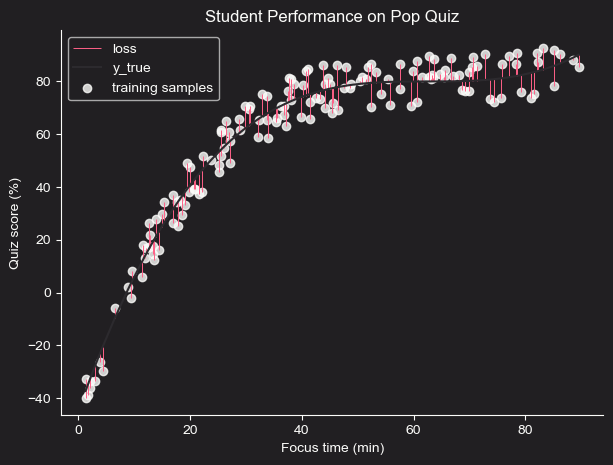

In [575]:
fig, ax = plt.subplots(figsize=(7,5))

mm = np.sort(np.vstack([y, y_true]), axis=0)
ax.vlines(x=x, ymin=mm[0], ymax=mm[1], color=c_['red'], label='loss', linewidth=0.7)
ax.plot(x, y_true, c=c_['grey'], label='y_true')
ax.scatter(x, y, c=c_['white'], label='training samples', alpha=0.8)

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(c_['white'])

ax.set_title('Student Performance on Pop Quiz')
ax.set_xlabel('Focus time (min)')
ax.set_ylabel('Quiz score (%)')
ax.legend(loc='upper left');

print(f'cost over all examples: {cost_mse(y_true, y)}');

### Splitting Dataset

Now we separate the dataset into three parts:

* **Training set (60%)** → used to train the model  
* **Validation set (20%)** → used to tune hyperparameters and evaluate performance during training  
* **Test set (20%)** → used to assess final performance on unseen data


In [556]:
def train_test_split(X, y, p_train=0.6):
    n = X.shape[0]
    sample_indicies = np.arange(0, n)
    train_mask = np.random.choice(sample_indicies, size=int(p_train * n), replace=False)
    test_mask = sample_indicies[~np.isin(sample_indicies, train_mask)]
    
    return X[train_mask], y[train_mask], X[test_mask], y[test_mask]

In [557]:
np.random.seed(SEED+1)
x_train, y_train, _x, _y = train_test_split(x, y, 0.5)
x_cv, y_cv, x_test, y_test = train_test_split(_x, _y, 0.5)

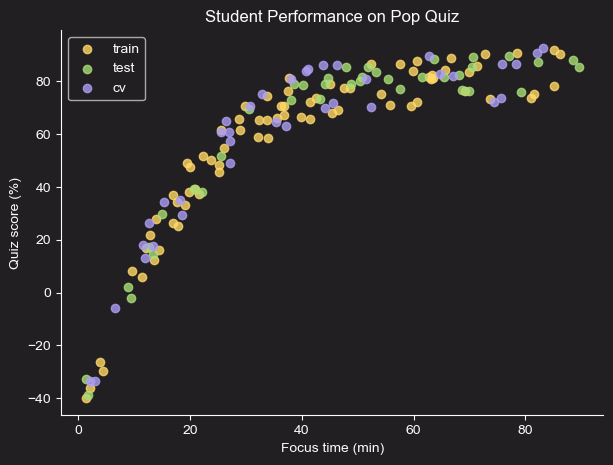

In [578]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x_train, y_train, c=c_['yellow'], label='train', alpha=0.8)
ax.scatter(x_test, y_test, c=c_['green'], label='test', alpha=0.8)
ax.scatter(x_cv, y_cv, c=c_['purple'], label='cv', alpha=0.8)

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(c_['white'])
ax.set_title('Student Performance on Pop Quiz')
ax.set_xlabel('Focus time (min)')
ax.set_ylabel('Quiz score (%)')
ax.legend(loc='upper left');

### Gradient Descent

Gradient Descent is an optimization algorithm used to train machine learning models. Its purpose is to iteratively adjust a model's weigh values to minimize the cost function $J$.

The graident $\nabla{\vec{J}}$ is a vector of all the partial derivatives of the cost function w.r.t each weight $w_j$.

$$\nabla\vec{J} = \begin{pmatrix}
\\
\frac{dJ}{dw_0}\\\\
\frac{dJ}{dw_1} \\\\
.\\
.\\
. \\\\
\frac{dJ}{dw_n} \\ \\

\end{pmatrix}$$

The cost function expanded is:
$$J(w,X) = \frac{1}{2m}\sum^{m}_{i = 1}(w_0x_{0}^{(i)} + w_1x_{1}^{(i)} + ... + w_nx_{n}^{(i)} - y^{(i)})^2$$

The partial derivatives w.r.t to each weight is:

$$\frac{dJ}{dw_j} = \frac{1}{m}\sum^{m - 1}_{i = 0}(\vec{w}^T\vec{x}^{(i)} - y^{(i)})x_{j}^{(i)}$$
$$\frac{dJ}{dw_0} = \frac{1}{m}\sum^{m - 1}_{i = 0}(\vec{w}^T\vec{x}^{(i)} - y^{(i)})$$

The partial derivatives tell us the direction and magnitude to update each weight and move close to the minimum cost.



In [559]:
def linear_compute_gradient(X, y, w):
    m = X.shape[0]
    n = X.shape[1]
    g_w = np.zeros(n)
    
    y_hat = linear_predict(X, w)
    g_w[0] = np.sum(y_hat - y)/m # for bias unit
    for i in range(1, n):
        g_w[i] = np.sum((y_hat - y) * X[:, i])/m # for all other weights
    
    return g_w

The **update rule** for gradient descent is:

$$
\text{while } \Delta{J} > \epsilon: \;\vec{w} \;\leftarrow\; \vec{w} - \eta \nabla J(\vec{w})
$$

where $\eta < 1$ (e.g., $0.001$).


In [560]:
def linear_gradient_descent(X, y, w, eta=0.001, threshold=0.005, max_iter = 1000):
    message = True
    max_delta = 1e+20 # to prevent infinite divergence
    m = X.shape[0]
    
    cost_list = []
    grad_norm_list = []
    
    iterations = 1
    delta_cost = math.inf
    y_hat = linear_predict(X, w)
    old_cost = cost_mse(y_hat, y)

    while delta_cost >= threshold: # threshold is epsilon
        
        iterations += 1
        g_w = linear_compute_gradient(X, y, w)
        grad_norm_list.append(np.sqrt(np.sum(g_w**2)))
        w = w - eta*g_w
        
        y_hat = linear_predict(X, w)
        new_cost = cost_mse(y_hat, y) 
        
        delta_cost = np.abs(old_cost - new_cost)
        cost_list.append(new_cost)
        old_cost = new_cost
        
        if delta_cost > max_delta:
            print(f'# of iterations (divergent): {iterations}')
            message = False
            break
    
    if message:
        print(f'# of iterations: {iterations}')
    
    return (w, np.array(cost_list), np.array(grad_norm_list))

### Feature Scaling

Feature scaling is a **preprocessing step** where you transform features so that they share similar scales (whether range or distribution).

Common techniques include:
* **Normalization** (Min-Max scaling): rescales all values to a fixed range, usually $[0,1]$
* **Standardization** (Z-score scaling): centers data to mean of $0$ and standard deviation of $1$.

In [561]:
# standardiazation
class StandardScaler():
    def __init__(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
    
    def scale(self, X):
        return (X - self.mean)/self.std
        

In [562]:
scaler = StandardScaler(x_train)
x_train_scaled = scaler.scale(x_train)
x_cv_scaled = scaler.scale(x_cv)
x_test_scaled = scaler.scale(x_test)

In [563]:
X_train_scaled = add_ones(x_train_scaled)
X_train = add_ones(x_train)

w_rand = np.random.rand(X_train_scaled.shape[1])
w_rand[0] = 0 # bias unit set to 0

w1, cost_list1, grad_list1 = linear_gradient_descent(X_train_scaled, y_train, w_rand)
w2, cost_list2, grad_list2= linear_gradient_descent(X_train, y_train, w_rand);
print(f'weights with feature scaling: {w1}')
print(f'weights without feature scaling: {w2}')

# of iterations: 3333
# of iterations (divergent): 156
weights with feature scaling: [55.34459847 24.42748597]
weights without feature scaling: [1.33550275e+07 7.11608090e+08]


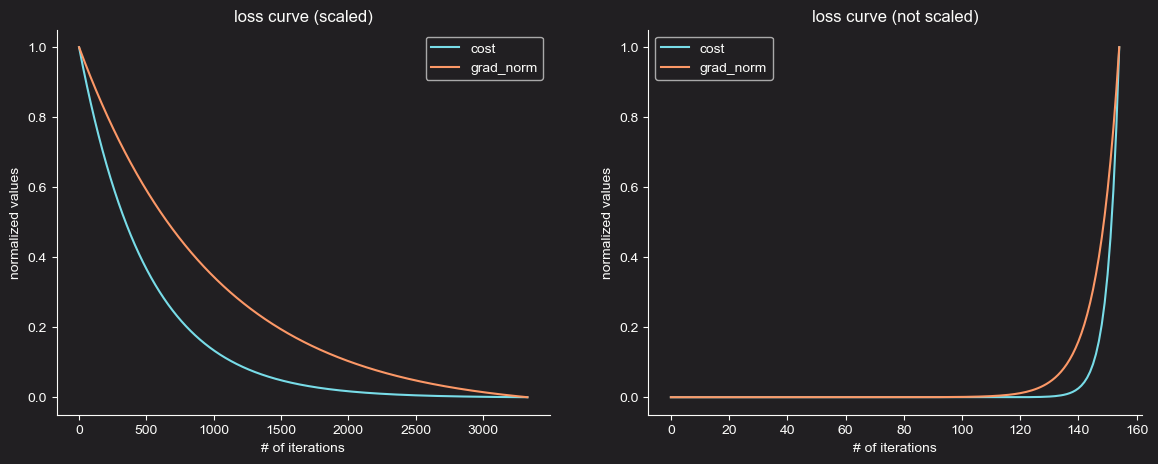

In [564]:
def normalize(X):
        return (X - X.min())/(X.max() - X.min())
        
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cost_arr = [cost_list1, cost_list2]
grad_arr = [grad_list1, grad_list2]
name_arr = ['scaled', 'not scaled']
for i in range(len(cost_arr)):
        axes[i].set_title(f'loss curve ({name_arr[i]})')
        axes[i].set_xlabel('# of iterations')
        axes[i].set_ylabel('normalized values')
        axes[i].plot(np.arange(len(cost_arr[i])), normalize(cost_arr[i]), c=c_['blue'], label='cost')
        axes[i].plot(np.arange(len(grad_arr[i])), normalize(grad_arr[i]), c=c_['orange'], label='grad_norm')
        axes[i].spines[['top', 'right']].set_visible(False)
        axes[i].spines[['bottom', 'left']].set_color(c_['white'])
        axes[i].legend()

As you can see, without feature scaling, gradient descent failed to reach a minimum and instead **increased at each iteration** (diverged). This happened because:

1. Different feature scales cause **elongated contours**.
2. Elongated contours create **imbalanced updates** where

   * high-scale feature dimensions take large steps
   * low-scale feature dimensions take tiny steps
3. Imbalanced steps cause **oscillation**, a zig-zag path across the valley (the area around the minimum point) instead of converging smoothly.
4. High-scale features are too large for the learning rate, resulting in **divergence**—the cost grows rather than shrinks.

Feature scaling is also **important** for several reasons. Most commonly, it:

* **improves gradient descent convergence** *(contours become more spherical)*
* **equalizes feature influence** on the inference of a model *(larger feature values do not always mean greater importance)*
* helps in **understanding feature importance** *(since all features are on the same scale)*

### Model Diagnostics & Tuning

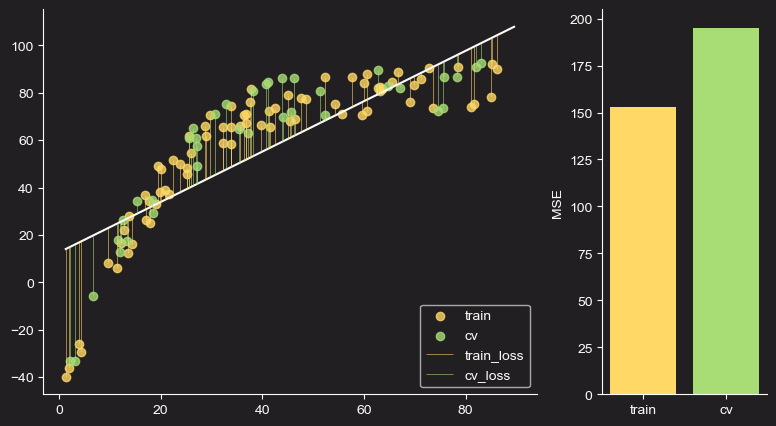

In [579]:
y_pred_train = linear_predict(add_ones(x_train_scaled), w1)
y_pred_cv = linear_predict(add_ones(x_cv_scaled), w1)
y_pred = linear_predict(add_ones(scaler.scale(x)), w1)

train_err = np.sort(np.vstack([y_train, y_pred_train]), axis=0)
cv_err = np.sort(np.vstack([y_cv, y_pred_cv]), axis=0)

fig, ax = plt.subplots(1, 2, figsize=(7+(7/3), 5), gridspec_kw={'width_ratios': [3, 1]})

ax[0].plot(x, y_pred, c=c_['white'])
ax[0].scatter(x_train, y_train, c=c_['yellow'], label='train', alpha=0.8)
ax[0].scatter(x_cv, y_cv, c=c_['green'], label='cv', alpha=0.8)
ax[0].vlines(x=x_train, ymin=train_err[0], ymax=train_err[1], color=c_['yellow'], label='train_loss', linewidth=0.4)
ax[0].vlines(x=x_cv, ymin=cv_err[0], ymax=cv_err[1], color=c_['green'], label='cv_loss', linewidth=0.4)

ax[1].bar(['train', 'cv'],
          [cost_mse(y_train, y_pred_train), cost_mse(y_cv, y_pred_cv)],
          color=[c_['yellow'], c_['green'], c_['red']])
ax[1].set_ylabel('MSE')

for axes in ax.flat:
    axes.spines[['top', 'right']].set_visible(False)
    axes.spines[['bottom', 'left']].set_color(c_['white'])

ax[0].legend(loc='lower right');

* the current models shows poor ability to capture the relationship between the feature and target vairrbles and generatlization for unseen examples.

In [566]:
class LinearRegression():
    
    def __init__(self):
        self.weight = None # w_0 + w_1 + ... + w_n
        self.cost_list = None # L
        self.grad_list = None # gradient norm
        
    def _cost_mse(self, y_hat, y):
        return np.sum((y_hat - y)**2)/(2*y.shape[0])
    
    def _add_ones(self, arr):
        one_arr = np.ones(arr.shape[0])
        if arr.ndim == 1:
            return np.vstack([one_arr, arr]).T 
        return np.hstack([one_arr.reshape(-1,1), arr])
        
    def fit(self, X, y, eta=0.01, max_iter=1000):
        
        m = X.shape[0]
        n = X.shape[1]
        
        X_new = self._add_ones(X)
        
        w_rand = np.random.rand(n + 1)
        w_rand[0] = 0
        self.weight = w_rand
        
        self._gradient_descent(X_new , y, eta=eta, threshold=0.005, max_iter=max_iter)


    def predict(self, X, external=True):
        if external:
            return self._add_ones(X) @ self.weight
        else:
            return X @ self.weight

    def _compute_gradient(self, X, y):
        m = X.shape[0]
        n = X.shape[1]
        
        y_hat = self.predict(X, external=False)
        g_w = np.zeros(n)
        
        g_w[0] = np.sum(y_hat - y)/m
        
        for i in range(1, n):
            g_w[i] = np.sum((y_hat - y) * X[:, i])/m
        
        return g_w
    
    def _gradient_descent(self, X, y, eta, threshold, max_iter):
        delta_cost = math.inf
        y_hat = self.predict(X, external=False)
        old_cost = self._cost_mse(y_hat, y)
        max_delta = 1e+20
        
        self.cost_list = [old_cost]
        self.grad_list = [self._compute_gradient(X, y)]
        
        iterations = 0
        while delta_cost >= threshold:
            
            iterations += 1
            
            g_w = self._compute_gradient(X, y)
            self.grad_list.append(np.sqrt(np.sum(g_w**2)))
            self.weight =self.weight - eta*g_w
            
            y_hat = self.predict(X, external=False)
            new_cost = self._cost_mse(y_hat, y) 
            
            delta_cost = np.abs(old_cost - new_cost)
            self.cost_list.append(new_cost)
            old_cost = new_cost
            
            if delta_cost > max_delta:
                print(f'[error]: gradient descent diverged')
                break
        
        print(f'[complete]: # of iter: {iterations}')

#### Bias Variance Trade-off

$$E[y_0 - \hat{f}(x_0)^2]= Var(\hat{f}(x_0)) + [Bias(\hat{f}(x_0))]^2 + Var(\epsilon)$$

* This equation breakdowns the components of the expected MSE for inference.
    * Variance: the amount by which $\hat{f}$ would change if we
estimated it using a different training data set.
    * (squared) bias: error that is introduced when approximating a complicated relationship with a simpler model.
    * variance of $\epsilon$: the error term $\epsilon$ comes from
        $$Y = f(x) + \epsilon$$
    
    which shows that even we find the true relationship between the target variable and features, _irreducible error_ will always exist (noise created by unknown features).


3 cases of bias vs variance
* high bias & low variance (underfitting): model is too simple to capture the complexity of the data, which makes consistent poor predictions. The variance is low as it does not overfit to any specific dataset.
* low bias & high variance (overfitting): model is complex enough to capture the data complexity, but now is easily sensitive to noise, leading to poor generalization. 
* balanced bias & variance: model is just fit enough to capture the data's pattern without overfitting or underfitting
* Ideally, the goal is to pick a model that has _low variance_ and _low_bias_

In [567]:
def generate_degree(x, d_num):
    xd_list = [x]
    for d in range(2, d_num+1):
        xd_list.append(np.round(x**d, 5))
    
    return np.vstack(xd_list).T
    

In [568]:
degree = 5
train_cv_error = np.zeros((degree, 2))
fitted_model = []
for i in range(degree):
    X_scaled = generate_degree(scaler.scale(x), i+1)
    X2_train_scaled = generate_degree(x_train_scaled, i+1)
    X2_cv_scaled = generate_degree(x_cv_scaled, i+1)
    
    model = LinearRegression()
    
    model.fit(X2_train_scaled, y_train)
    fitted_model.append(model.predict(X_scaled))
    
    train_cv_error[i, 0] = cost_mse(model.predict(X2_train_scaled), y_train)
    train_cv_error[i, 1] = cost_mse(model.predict(X2_cv_scaled), y_cv)

[complete]: # of iter: 447
[complete]: # of iter: 1030
[complete]: # of iter: 1032
[complete]: # of iter: 2099
[complete]: # of iter: 2103


In [569]:
c_iter = iter(c_)
next(c_iter)

'red'

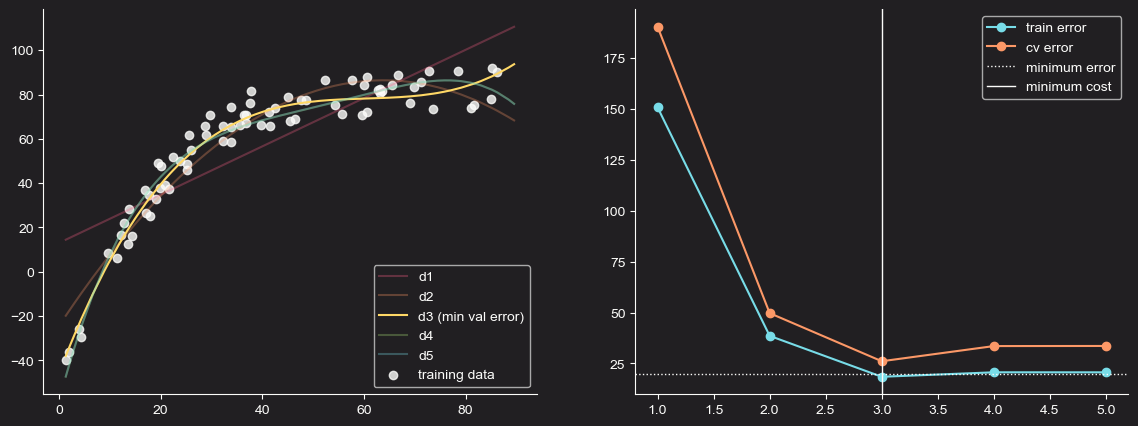

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
opti_degree = train_cv_error[:, 1].argmin() + 1
c_iter = iter(c_)
alpha_val = 0.3
label_val = None


for i in range(degree):
    if i == opti_degree - 1:
        alpha_val = 1; label_val = f'd{i+1} (min val error)'
    else:
        alpha_val = 0.3; label_val = f'd{i+1}'
        
    ax[0].plot(x, fitted_model[i], c=c_[next(c_iter)], alpha = alpha_val, label=label_val)

ax[0].scatter(x_train, y_train, c=c_['white'], label='training data', alpha = 0.8)

ax[1].plot(np.arange(1, degree + 1), train_cv_error[:, 0], label='train error', c=c_['blue'], marker='o')
ax[1].plot(np.arange(1, degree + 1), train_cv_error[:, 1], label='cv error',c=c_['orange'], marker='o')
ax[1].axhline(y=ERROR*2, color=c_['white'], linestyle=':', linewidth=1, label='minimum error')
ax[1].axvline(x=opti_degree, color=c_['white'], linewidth=1, label='minimum cost')
for axes in ax.flat:
    axes.spines[['top', 'right']].set_visible(False)
    axes.spines[['bottom', 'left']].set_color(c_['white'])

ax[0].legend(loc='lower right');
ax[1].legend(loc='upper right');

* Increasing the degree of freedom - by adding addtional terms with higher degrees - shows the model to fit closer to $f(x)$, the true relationship.
* looking at the right graph, the model with _dof_ of 4 is chosen. Any more increase in _dof_ shows increase in the validation error, while the training error continues to decrease. This is beause the model is ovefitting to noise in the training set. As a result, generalization capabilities decrease.

### Testing Model

In [600]:
X_opti_train_scaled = generate_degree(x_train_scaled, opti_degree)
X_opti_cv_scaled = generate_degree(x_cv_scaled, opti_degree)
X_opti_test_scaled = generate_degree(x_test_scaled, opti_degree)
model = LinearRegression()
model.fit(X_opti_train_scaled, y_train)

[complete]: # of iter: 1031


In [623]:
y_pred_opti = model.predict(X_opti_test_scaled)
print(f'polynomial regression model (d={opti_degree}):',cost_mse(y_pred_opti, y_test))

polynomial regression model (d=3): 14.65464495159606


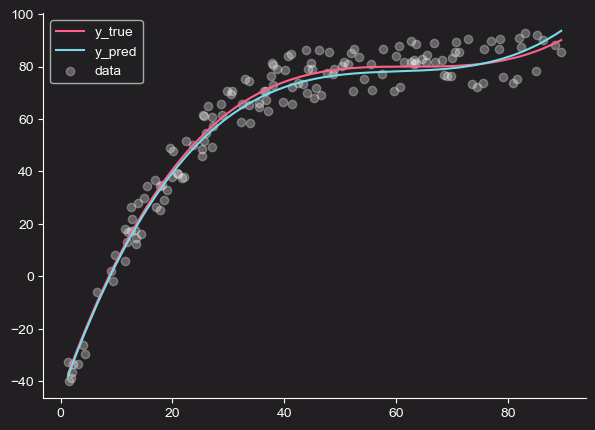

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
X_scaled = generate_degree(scaler.scale(x), opti_degree)
y_pred = model.predict(X_scaled)
ax.plot(x, y_true, c=c_['red'], label='y_true')
ax.plot(x, y_pred, c=c_['blue'], label='y_pred' )
ax.scatter(x, y, c=c_['white'], label='data', alpha = 0.3)

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(c_['white'])
ax.legend()


#### Regularization

### Testing Model Performance

## Logistic Regression

* error analysis: look at a specific example that is being mis calssified
* classification metrics

hyperparameter tuning (cv_cost & train_cost) -> pick minimum cv_cost